In [41]:
import networkx as nx 
import random
import json


In [48]:
blacklist = ['intrusion-set--68ba94ab-78b8-43e7-83e2-aed3466882c6']
data_dir = "../datasets/ics_attack/"
# Load the JSON data for attack graph
with open(data_dir+'attack-graph.json', 'r') as file:
    a_graph_data = json.load(file)
print("len of links: ",len(a_graph_data['links']))
# Create dictionary to store the id_pos and pos_id mapping
id_to_pos = {}
pos_to_id = {}


len of links:  781


In [49]:
# Create a new graph
a_graph = nx.Graph()
# Add nodes
for node in a_graph_data['nodes']:
    a_graph.add_node(node['id'], **node)
# Add edges
for i in range(len(a_graph_data['links'])):
    source = a_graph_data['links'][i]['source']
    target = a_graph_data['links'][i]['target']
    if(source not in id_to_pos and source not in blacklist):
        pos = len(id_to_pos.keys())
        id_to_pos[source] = pos
        pos_to_id[pos]=source
    if(target not in id_to_pos and target not in blacklist):
        pos = len(id_to_pos.keys())
        id_to_pos[target] = pos
        pos_to_id[pos]=target
    a_graph.add_edge(source, target)
    #a_graph.add_edge(target, source, weight=1.0-a_graph_data['links'][i]['similarity'])
    # G_all_sim.add_edge(source, target)

In [50]:
a_graph.number_of_edges(), a_graph.number_of_nodes()

(781, 204)

In [51]:
attack_size=len(id_to_pos)
attack_size

203

In [52]:
# Create a new graph for weakness data
with open(data_dir+'cwe-graph.json') as f:
    w_graph_data = json.load(f)
w_graph = nx.Graph()
# Add nodes
for node in w_graph_data['nodes']:
    w_graph.add_node(node['ID'], **node)

# Add edges
for i in range(len(w_graph_data['links'])):
    source = w_graph_data['links'][i]['source']
    target = w_graph_data['links'][i]['target']
    if(source not in id_to_pos):
        pos = len(id_to_pos.keys())
        id_to_pos[source] = pos
        pos_to_id[pos]=source
    if(target not in id_to_pos):
        pos = len(id_to_pos.keys())
        id_to_pos[target] = pos
        pos_to_id[pos]=target
    w_graph.add_edge(source, target)
    #w_graph.add_edge(target, source, weight=1.0-link['similarity'])
    # G_all_sim.add_edge(source, target)

In [53]:
weak_size = len(id_to_pos)-attack_size
weak_size

933

In [54]:
# Get all connections and shortest path according to hop distance

def get_shortest_path(graph_data, graph):
    all_links = []
    count = 0
    w_dict = {}
    for source in graph.nodes:
        
        for target in graph.nodes: #len(graph_data['links']
            
            if(source==target or (source,target) in w_dict or (target,source) in w_dict):
                continue

            # following line give shortest path according to the weight
            # dist2 = nx.shortest_path_length(graph,source,target2, weight='weight')
            # Following line gives shortes path according to hop distance
            try:
                dist = nx.shortest_path_length(graph,source,target)
                # if((source,target) in w_dict and w_dict[(source,target)]<dist):
                #     dist=w_dict[(source,target)]
                #     print("duplicate", source, " ",target)
                # elif((target,source) in w_dict and w_dict[(target,source)]<dist):
                #     dist=w_dict[(source,target)]
                #     print("duplicate", source, " ",target)
                w_dict[(source,target)] = dist
                #w_dict[(target,source)] = dist
            except:
                count+=1
                #print("No path between "+source+" ",target )
    print("No path: ", count)
    return w_dict

In [55]:
# len = 490891 without visited
# len = 11801 with visited
attack_w_dict = get_shortest_path(a_graph_data,a_graph)


No path:  0


In [56]:
len(attack_w_dict)

20706

In [57]:
weakness_w_dict = get_shortest_path(w_graph_data, w_graph)

No path:  0


In [58]:
len(weakness_w_dict.keys())

434778

In [59]:
a_mx_dist = max(list(attack_w_dict.values()))
print(a_mx_dist)

7


In [60]:
w_mx_dist = max(list(weakness_w_dict.values()))
print(w_mx_dist)

13


In [61]:
def create_training(weight_dict):
    pair_data = []
    missing_nodes = set()
    mx_dist = max(list(weight_dict.values()))
    print("max distance ", mx_dist)
    for key in weight_dict.keys():
        if(key[0] in id_to_pos):
            source_id = id_to_pos[key[0]]
            if(key[1] in id_to_pos):
                target_id = id_to_pos[key[1]]
                pair_data.append([source_id,target_id, weight_dict[key]/float(mx_dist)])
            else:
                missing_nodes.add(key[1])
        else:
            missing_nodes.add(key[0])
    print(missing_nodes)
    return pair_data, missing_nodes

In [62]:
all_attack_dist, missing_attack = create_training(attack_w_dict)

max distance  7
{'intrusion-set--68ba94ab-78b8-43e7-83e2-aed3466882c6'}


In [63]:
all_weakness_dist, missing_weakness = create_training(weakness_w_dict)

max distance  13
set()


In [64]:
training_data = all_attack_dist+all_weakness_dist
len(training_data)

455281

In [65]:
all_weakness_dist[0]

[203, 204, 0.07692307692307693]

In [66]:
all_attack_dist_norm = [x for _,_,x in all_attack_dist]

In [67]:
all_weakness_dist_norm = [x for _,_,x in all_weakness_dist]

In [68]:

# one_path_attack_dist = [1.0-item['similarity'] for item in graph_data['links']]
# len(one_path_attack_dist)

In [69]:
import matplotlib.pyplot as plt

def histogram(all_sim,file, title):
    # Plot histogram with 5 bins
    plt.hist(all_sim, bins=50, edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.savefig(file, dpi=300)
    # Show plot
    plt.show()

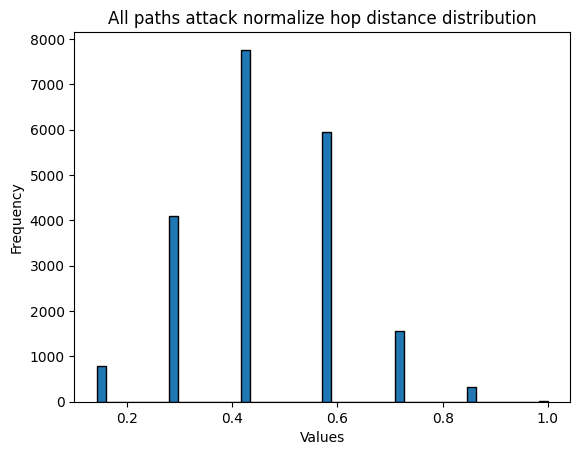

In [70]:
histogram(all_attack_dist_norm,data_dir+'plots/attack_norm_hop_distance_distribution.png', 'All paths attack normalize hop distance distribution')

In [71]:
attack_hop_dist = [x*a_mx_dist for _,_,x in all_attack_dist]

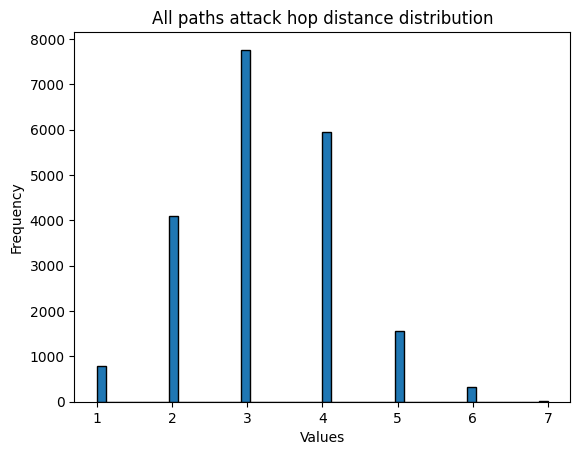

In [72]:
histogram(attack_hop_dist,data_dir+'plots/attack_hop_distance_distribution.png', 'All paths attack hop distance distribution')

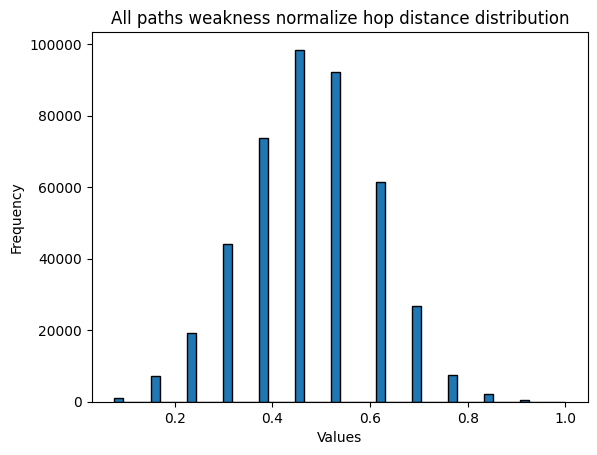

In [73]:
histogram(all_weakness_dist_norm,data_dir+'plots/weakness_norm_hop_distance_distribution.png', 'All paths weakness normalize hop distance distribution')

In [74]:
weakness_hop_dist = [x*w_mx_dist for _,_,x in all_weakness_dist]

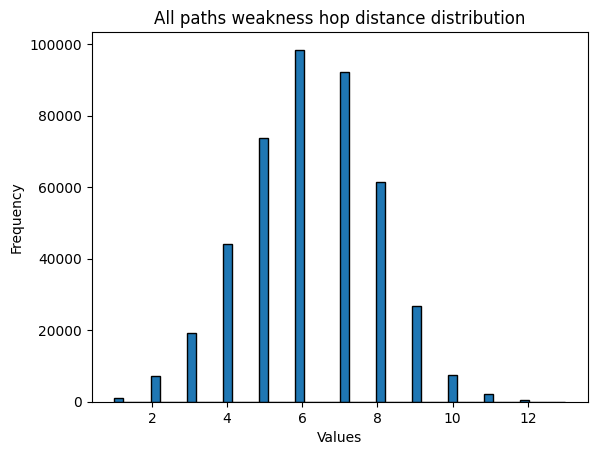

In [75]:
histogram(weakness_hop_dist,data_dir+'plots/weakness_hop_distance_distribution.png', 'All paths weakness hop distance distribution')

In [76]:
training_data = all_attack_dist+all_weakness_dist

In [77]:
len(training_data)

455281

In [78]:
import numpy as np
np.save(data_dir+'hop_training_data.npy', np.array(training_data)) # save
#new_num_arr = np.load('data.npy') # load

In [79]:
with open(data_dir+'doc_id_to_emb_id.json','w') as fp:
    json.dump(id_to_pos,fp)
with open(data_dir+'emb_id_to_doc_id.json','w') as fp:
    json.dump(pos_to_id,fp)


In [80]:
def get_hop_sim_matrix(all_dist, size, isAttack):
    hop_sim_matrix = [[0 for _ in range(size)] for _ in range(size)]
    for n1,n2,dist in all_dist:
        if(not isAttack):
            n1=n1-attack_size
            n2=n2-attack_size
        # print("n1",n1)
        # print("n2",n2)
        
        hop_sim_matrix[n1][n2]=1.0001-dist
        hop_sim_matrix[n2][n1]=1.0001-dist
    return hop_sim_matrix

In [81]:
weakness_hop_sim_matrix = get_hop_sim_matrix(all_weakness_dist, weak_size, False)

In [82]:
attack_hop_sim_matrix = get_hop_sim_matrix(all_attack_dist, attack_size, True)

In [83]:
count=0
for i in range(len(attack_hop_sim_matrix)):
    for j in range(len(attack_hop_sim_matrix[0])):
        if(attack_hop_sim_matrix[i][j]==0):
            count+=1
print(count)

203


In [84]:
np.save(data_dir+'weakness_hop_sim_matrix.npy', np.array(weakness_hop_sim_matrix)) # save

In [85]:
np.save(data_dir+'attack_hop_sim_matrix.npy', np.array(attack_hop_sim_matrix)) # save